# Pointcloud processing

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Outlier rejection

In [41]:
ply_file_path = "/calibration/data/scanner/stitched_pc.ply"  # Replace with your .ply file path
pcd = o3d.io.read_point_cloud(ply_file_path)
# Apply a transformation if needed (e.g., rotating or translating the point cloud)
# For example, a 90-degree rotation around the x-axis can be done as follows:
rotation_matrix = pcd.get_rotation_matrix_from_xyz((np.pi / 2, np.pi, 0))
pcd.rotate(rotation_matrix, center=(0, 0, 0))

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

points_np = np.asarray(pcd.points)

# Calculate the centroid of the point cloud
centroid = np.mean(points_np, axis=0)

# Translate the point cloud so that the centroid moves to the origin
centered_points_np = points_np - centroid

# Update the point cloud with the centered points
pcd.points = o3d.utility.Vector3dVector(centered_points_np)

# Create a coordinate frame for reference
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

# Visualize the centered point cloud and the coordinate frame
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(coordinate_frame)
vis.run()
vis.destroy_window()

In [42]:
def display_inlier_outlier(cloud, ind):
    
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [43]:
cleaned_pcd, ind = pcd.remove_statistical_outlier(
    nb_neighbors=20,
    std_ratio=1.5
)

display_inlier_outlier(pcd, ind)

Showing outliers (red) and inliers (gray): 


### ROI filtering

In [44]:
TOOLS_MIN_LENGTH = 0.02
TOOLS_MAX_LENGTH = 0.03
# OPTIONAL
CLIP_FLOOR       = 0.008

In [45]:
points = np.asarray(cleaned_pcd.points)
colors = np.asarray(cleaned_pcd.colors)

In [46]:
farest_distance = np.min(points[:, 2])
lowest_distance = np.min(points[:,1])

# Remove background noise
bg_mask = np.array([points[:, 2] >= farest_distance + (TOOLS_MIN_LENGTH - 0.1 * TOOLS_MIN_LENGTH)])

# Remove foreground noise
fg_mask = np.array([points[:, 2] <= farest_distance + TOOLS_MAX_LENGTH])

# Remove floor noise
fl_mask =  np.array([points[:, 1] >= lowest_distance + CLIP_FLOOR])


filtered_mask = (fg_mask & bg_mask & fl_mask).flatten()

In [47]:
# Filter out points below the Z threshold
filtered_points = points[filtered_mask]
filtered_colors = colors[filtered_mask]

# Create a new point cloud with the filtered points
filtered_point_cloud = o3d.geometry.PointCloud()
filtered_point_cloud.points = o3d.utility.Vector3dVector(filtered_points)
filtered_point_cloud.colors = o3d.utility.Vector3dVector(filtered_colors)

# Create a coordinate frame for reference
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

# Visualize the centered point cloud and the coordinate frame
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(filtered_point_cloud)
vis.add_geometry(coordinate_frame)
vis.run()
vis.destroy_window()

### Tool candidates

In order to detect tool candidates, we perform clustering on the obtained point cloud. For each cluster we then extract the relative point cloud

In [48]:
from sklearn.cluster import DBSCAN
pcd = filtered_point_cloud

points = np.asarray(filtered_point_cloud.points)
colors = np.asarray(filtered_point_cloud.colors)

scan       = DBSCAN(eps = 0.0075, min_samples=250)
clusters   = scan.fit(points)

labels     = np.unique(clusters.labels_)
labels     = labels[labels >= 0] 
n_clusters = len(labels) 

detected_tool_pcds = []
colors = np.random.rand(n_clusters + 1, 3)  # Random colors for each cluster + noise

for i in range(0, n_clusters):
    cluster_id = labels[i]
    cluster_points = np.array([pt for pt, label in zip(points, clusters.labels_) if label == cluster_id])
    
    tool_pcd = o3d.geometry.PointCloud()
    tool_pcd.points = o3d.utility.Vector3dVector(cluster_points)
    tool_pcd.paint_uniform_color(colors[cluster_id])
    detected_tool_pcds.append(tool_pcd)

# Visualize the centered point cloud and the coordinate frame
vis = o3d.visualization.Visualizer()
vis.create_window()

for tool_pcd in detected_tool_pcds:
    vis.add_geometry(tool_pcd)

vis.add_geometry(coordinate_frame)
vis.run()
vis.destroy_window()

### Rasterization

In [72]:
import os

tools_pcds = []
for tool in os.listdir('/calibration/objects/tools'):
    if tool.endswith('.stl'):
            mesh = o3d.io.read_triangle_mesh(f'/calibration/objects/tools/{tool}')
            pcd_poisson = mesh.sample_points_poisson_disk(number_of_points=75000)
            rotation_matrix = pcd_poisson.get_rotation_matrix_from_xyz((np.pi / 2, np.pi, 0))
            pcd_poisson.rotate(rotation_matrix, center=(0, 0, 0))
            tools_pcds.append(pcd_poisson)

In [73]:
import uuid

def rasterize (pcds):

    color_grid = None
    z_buffer   = None
    id_buffer  = None
    for idx, pcd in enumerate(pcds):
        # Convert the point cloud to numpy arrays
        points_np = np.asarray(pcd.points)
        points_np = points_np - np.mean(points_np, axis= 0)


        if color_grid is None:
            # Define grid size and range
            grid_size = 200
            x_min, y_min = np.min(points_np[:, :2], axis=0)
            x_max, y_max = np.max(points_np[:, :2], axis=0)
            
            # Create grid
            x_grid = np.linspace(x_min - 0.05, x_max + 0.05, grid_size)
            y_grid = np.linspace(y_min - 0.05, y_max + 0.05, grid_size)
            grid_x, grid_y = np.meshgrid(x_grid, y_grid)
            
            # Initialize the color grid
            color_grid = np.zeros((grid_size, grid_size, 3))  # RGB color grid

            # Initiliaze id buffer to detect overlaps
            id_buffer  = np.zeros((grid_size, grid_size))
            id_buffer.fill(-2)
            
            z_buffer   = np.zeros((grid_size, grid_size))
            z_buffer.fill(np.inf)
            
        # Populate the grid with point colors
        for point in points_np:
            x_idx = np.searchsorted(x_grid, point[0], side='right') - 1
            y_idx = np.searchsorted(y_grid, point[1], side='right') - 1
            if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size and z_buffer[y_idx, x_idx] >= point[2]:
                z_buffer[y_idx, x_idx]   = point[2]
                
                if (id_buffer[y_idx, x_idx] == -2):
                    id_buffer[y_idx, x_idx] = idx
                    color_grid[y_idx, x_idx] = [1/(idx+1), 1/(idx+1), 1/(idx+1)]
                elif (id_buffer[y_idx, x_idx] >= 0 and id_buffer[y_idx, x_idx] != idx):
                    id_buffer[y_idx, x_idx] = -1
                    color_grid[y_idx, x_idx] = [0, 1, 0]

    
    # Plot the color grid
    plt.figure(figsize=(8, 8))
    plt.imshow(color_grid, origin='lower', extent=[x_min, x_max, y_min, y_max])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Rasterized Point Cloud Projection with Colors (XY Plane)')
    plt.show()

    return id_buffer

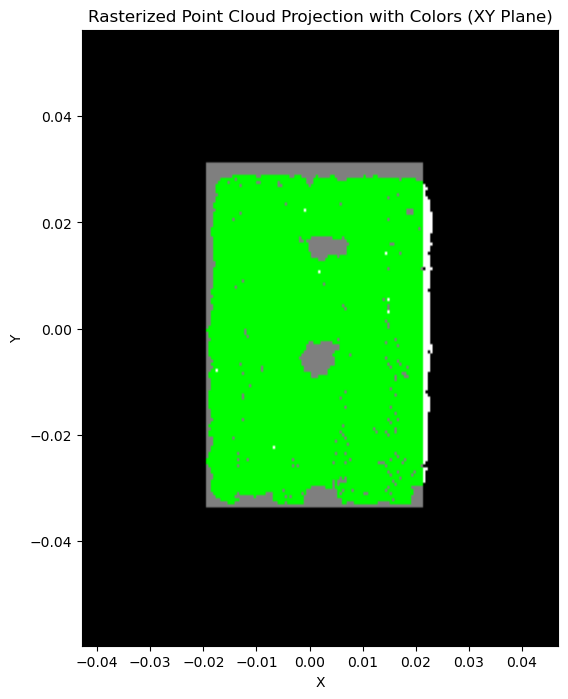

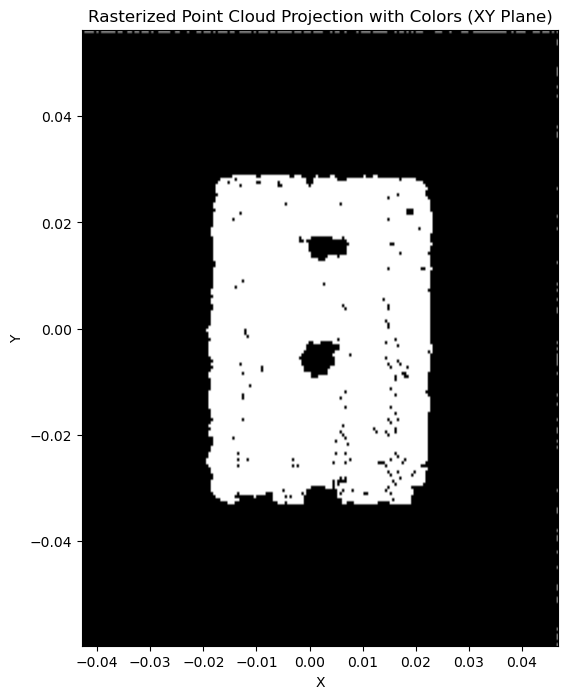

[[0.8473764841057067, 0.0]]


In [86]:
tools = []
for detected_tool_pcd in detected_tool_pcds:
    matches = []
    for tool_pcd in tools_pcds:
        id_buffer = rasterize([detected_tool_pcd, tool_pcd])
        fit = len(id_buffer[id_buffer == -1]) / len(id_buffer[id_buffer >= -1])
        matches.append(fit)
    tools.append(matches)
print(tools)